In [1]:
import keras
from keras.preprocessing.text import Tokenizer
import numpy as np
from keras.layers import *
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [2]:
with open('Dune.txt', 'r', encoding='utf-8') as f:
    texts = f.read()
    # убираем первый невидимый символ
    texts = texts.replace('\ufeff', '') 
    

In [3]:
len(texts)

52176

In [4]:
# набор уникальных слов
maxWordsCount = 8000
tokenizer = Tokenizer(num_words=maxWordsCount, 
                      filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»',
                      lower=True,
                      split=' ',
                      char_level=False)
tokenizer.fit_on_texts([texts])

In [5]:
dist = list(tokenizer.word_counts.items())
print(dist[:10])

[('дюна', 9), ('фрэнк', 2), ('герберт', 2), ('вселенная', 1), ('дюныхроники', 1), ('дюны', 1), ('1', 2), ('роман', 1), ('первая', 1), ('книга', 4)]


In [6]:
# преобразуем текст в последовательность чисел в соответсвии со словарем
data = tokenizer.texts_to_sequences([texts])

In [7]:
len(data[0])

7934

In [8]:
# категоризируем слова в вектор
res = keras.utils.to_categorical(data[0], num_classes=maxWordsCount)
print( res.shape )

(7934, 8000)


In [9]:
# число слов, на которых строится прогноз
inp_words = 3
n = res.shape[0]-inp_words

In [10]:
X = np.array([res[i:i+inp_words, :] for i in range(n)])
Y = res[inp_words:] 

In [11]:
model = Sequential([
    Input((inp_words, maxWordsCount)),
    SimpleRNN(128, activation='tanh'),
    Dense(maxWordsCount, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               1040512   
                                                                 
 dense (Dense)               (None, 8000)              1032000   
                                                                 
Total params: 2,072,512
Trainable params: 2,072,512
Non-trainable params: 0
_________________________________________________________________


У данной сети мы видим около 2 млн параметров

In [12]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [13]:
# Настраиваем защиту от переобучения
estop = EarlyStopping(monitor='accuracy', patience=2) 

In [14]:
%%time
history = model.fit(X, Y, batch_size=64, epochs=100, callbacks=estop)
if estop.stopped_epoch >= 1:
    print(f'Обучение остановлено на {estop.stopped_epoch} эпохе')

Epoch 1/100
124/124 [==============================] - 10s 67ms/step - loss: 8.2008 - accuracy: 0.0349
Epoch 2/100
124/124 [==============================] - 7s 59ms/step - loss: 7.2099 - accuracy: 0.0373
Epoch 3/100
124/124 [==============================] - 7s 59ms/step - loss: 7.0103 - accuracy: 0.0374
Epoch 4/100
124/124 [==============================] - 7s 56ms/step - loss: 6.8371 - accuracy: 0.0393
Epoch 5/100
124/124 [==============================] - 7s 56ms/step - loss: 6.6285 - accuracy: 0.0485
Epoch 6/100
124/124 [==============================] - 7s 56ms/step - loss: 6.3555 - accuracy: 0.0577
Epoch 7/100
124/124 [==============================] - 8s 64ms/step - loss: 6.0446 - accuracy: 0.0735
Epoch 8/100
124/124 [==============================] - 8s 65ms/step - loss: 5.6930 - accuracy: 0.0965
Epoch 9/100
124/124 [==============================] - 8s 63ms/step - loss: 5.3385 - accuracy: 0.1242
Epoch 10/100
124/124 [==============================] - 8s 64ms/step - loss: 4.97

In [15]:
print(f'Точность модели model: {100*history.history["accuracy"][-1]:.2f} %')

Точность модели model: 95.76 %


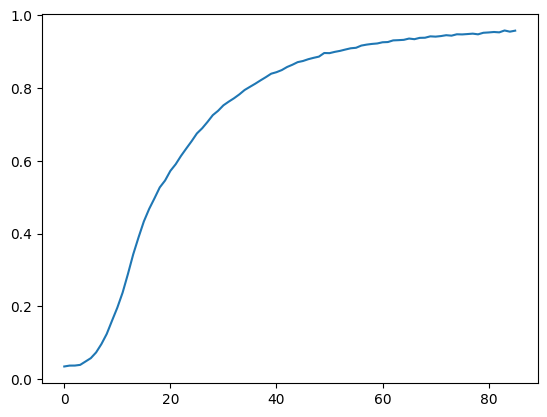

In [16]:
plt.plot(history.history['accuracy'])

In [17]:
def buildPhrase(texts, str_len = 30):
  res = texts
  data = tokenizer.texts_to_sequences([texts])[0]

  for i in range(str_len):
    x = keras.utils.to_categorical(data[i: i+inp_words], num_classes=maxWordsCount) # преобразуем в One-Hot-encoding
    inp = x.reshape(1, inp_words, maxWordsCount)

    pred = model.predict( inp, verbose=0 ) # предсказываем OHE четвертого символа
    indx = pred.argmax(axis=1)[0]
    data.append(indx)
 
    res += " " + tokenizer.index_word[indx] # дописываем строку
 
  return res

Подставим в нашу модель фразу "последнее время несколько"

In [18]:
res = buildPhrase("последнее время несколько")
print('Ожидаем увидеть: "последнее время несколько неспокоен. А сколько специи ешь? – Разве мои развлечения так дорого стоят? Вы возражаете против них, барон?.."')
print(f'Получаем результат: {res}')

Ожидаем увидеть: "последнее время несколько неспокоен. А сколько специи ешь? – Разве мои развлечения так дорого стоят? Вы возражаете против них, барон?.."
Получаем результат: последнее время несколько неспокоен а сколько специи ешь  разве мои развлечения так дорого стоят вы возражаете против них барон  мой дорогой питер удовольствия то нас и связывают неужели я стану против них возражать


Вывод: отличный результат. Модель предсказала текст слово в слово.

### 2 вариант
Попробуем немного модернизировать сеть, применив слой Embedding

Embedding - такой специальный входной слой, который помогает экономить память, т.к. входной тензор прошлой модели занимает в памяти много места. <br>
Суть работы слоя embedding заключается в том, что мы используем только связи нейрона, на который подается 1 из вектора, остальные умножаются на 0. <br>
Слой имеет вид: <br>
**keras.layers.Embedding(input_dim, output_dim, …, input_length)** , где 

* input_dim – число слов в словаре (это наш maxWordsCount)
* output_dim – число выходов
* input_length – размер входного вектора (inp_words)

In [27]:
res_data = np.array(data[0])
inp_words = 3
n = res_data.shape[0]-inp_words
x_text = np.array([res_data[i:i+inp_words] for i in range(n)])
next_text = keras.utils.to_categorical(res_data[inp_words:] , num_classes=maxWordsCount)

In [28]:
model_2 = Sequential([
    Embedding(maxWordsCount, 256, input_length=inp_words),
    SimpleRNN(128, activation='tanh'),
    Dense(maxWordsCount, activation='softmax')
])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 256)            2048000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_2 (Dense)             (None, 8000)              1032000   
                                                                 
Total params: 3,129,280
Trainable params: 3,129,280
Non-trainable params: 0
_________________________________________________________________


In [29]:
model_2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

In [30]:
%%time
history_2 = model_2.fit(x_text, next_text, batch_size=64, epochs=100, callbacks=estop)
if estop.stopped_epoch >= 1:
    print(f'Обучение остановлено на {estop.stopped_epoch} эпохе')

Epoch 1/100
124/124 [==============================] - 11s 70ms/step - loss: 8.2246 - accuracy: 0.0335
Epoch 2/100
124/124 [==============================] - 9s 69ms/step - loss: 7.1532 - accuracy: 0.0388
Epoch 3/100
124/124 [==============================] - 10s 77ms/step - loss: 6.7868 - accuracy: 0.0485
Epoch 4/100
124/124 [==============================] - 10s 83ms/step - loss: 6.3595 - accuracy: 0.0586
Epoch 5/100
124/124 [==============================] - 9s 69ms/step - loss: 5.9106 - accuracy: 0.0729
Epoch 6/100
124/124 [==============================] - 9s 69ms/step - loss: 5.4592 - accuracy: 0.0963
Epoch 7/100
124/124 [==============================] - 9s 70ms/step - loss: 4.9940 - accuracy: 0.1359
Epoch 8/100
124/124 [==============================] - 9s 70ms/step - loss: 4.5227 - accuracy: 0.1998
Epoch 9/100
124/124 [==============================] - 9s 70ms/step - loss: 4.0478 - accuracy: 0.2836
Epoch 10/100
124/124 [==============================] - 8s 68ms/step - loss: 3.

In [31]:
print(f'Точность модели model_2: {100*history_2.history["accuracy"][-1]:.2f} %')

Точность модели model_2: 97.62 %


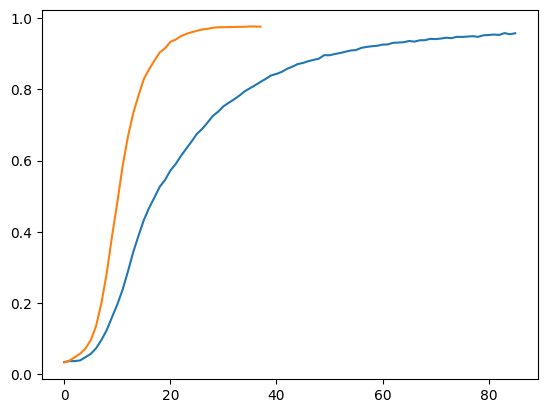

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history_2.history['accuracy'])


In [33]:
def buildPhrase_2(texts, str_len = 30):
  res = texts
  data = tokenizer.texts_to_sequences([texts])[0]

  for i in range(str_len):
    x = data[i: i+inp_words]
    inp = np.expand_dims(x, axis=0)

    pred = model_2.predict( inp, verbose=0 ) # предсказываем OHE четвертого символа
    indx = pred.argmax(axis=1)[0]
    data.append(indx)
 
    res += " " + tokenizer.index_word[indx] # дописываем строку
 
  return res

In [34]:
res_2 = buildPhrase_2("последнее время несколько")
print('Ожидаем увидеть: "последнее время несколько неспокоен. А сколько специи ешь? – Разве мои развлечения так дорого стоят? Вы возражаете против них, барон?.."')
print(f'Получаем результат: {res_2}')

Ожидаем увидеть: "последнее время несколько неспокоен. А сколько специи ешь? – Разве мои развлечения так дорого стоят? Вы возражаете против них, барон?.."
Получаем результат: последнее время несколько неспокоен а сколько специи ешь  разве мои развлечения так дорого стоят вы возражаете против них барон  мой дорогой питер удовольствия то нас и связывают неужели я стану против них возражать


Вывод: Вторая модель тоже предсказала текст в полном соответствии с оригиналом. Но ее обучение заняло меньше времени (5 минут против 12 у первой). Она достигла точности в 97,62% за 37 эпох, в то время как первая модель дошла только до 95,76% за больше количество (85) эпох.

### 